 Análise de Logs

A série temporal é uma coleção de pontos de dados coletados em intervalos de tempo constantes. 





In [2]:
import pandas as pd

dateparse = lambda dates: pd.to_datetime(dates)

df = pd.read_csv('logs3.csv', parse_dates = ['segundo'], index_col = 'segundo', date_parser = dateparse)

In [17]:
df.describe()

,requisicoes
count,873472.000000
mean,221.717761
std,169.950270
min,6.000000
25%,78.000000
50%,87.000000
75%,365.000000
max,456.000000


In [18]:
df.tail()



,requisicoes
segundo,
2022-04-30 04:28:59,456
2022-04-30 04:29:59,78
2022-04-30 04:30:59,453
2022-04-30 04:31:59,123
2022-04-30 04:32:59,87


Text(0, 0.5, 'Requisições')

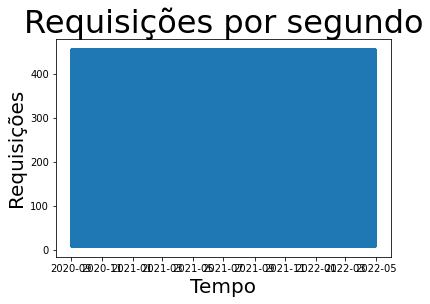

In [19]:
import matplotlib.pylab as plt

ts = df["requisicoes"]

plt.title(label="Requisições por segundo", fontsize=32)
plt.plot(ts)
plt.xlabel("Tempo", fontsize=20)
plt.ylabel("Requisições", fontsize=20)

Text(0, 0.5, 'Requisições')

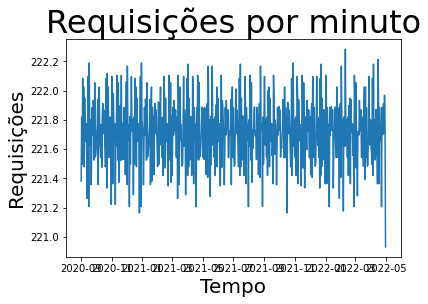

In [20]:
ts_1d = ts.resample('D', closed='right', label='left').mean()

plt.title(label="Requisições por minuto", fontsize=32)
plt.plot(ts_1d)
plt.xlabel("Tempo", fontsize=20)
plt.ylabel("Requisições", fontsize=20)

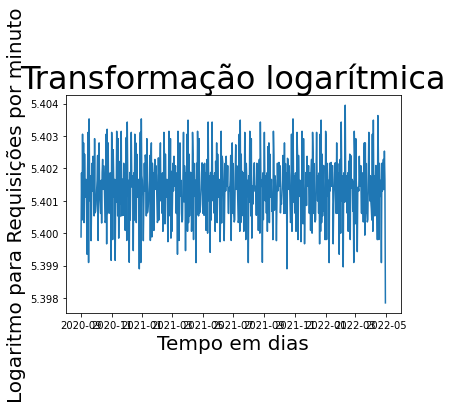

In [22]:
import numpy as np

ts_1d_log = np.log(ts_1d)

plt.title("Transformação logarítmica", fontsize=32)
plt.xlabel("Tempo em dias", fontsize=20)
plt.ylabel("Logaritmo para Requisições por minuto", fontsize=20)
plt.plot(ts_1d_log)

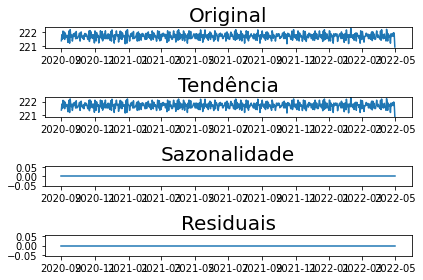

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decompose_analysis(timeseries, model, periods):
    decomposition = seasonal_decompose(timeseries, model = model, period = 1)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.title('Original', fontsize=20)
    plt.plot(timeseries, label='Original')
    plt.subplot(412)
    plt.title('Tendência', fontsize=20)
    plt.plot(trend, label='Tendência')
    plt.subplot(413)
    plt.title('Sazonalidade',fontsize=20)
    plt.plot(seasonal,label='Sazonalidade')
    plt.subplot(414)
    plt.title('Residuais', fontsize=20)
    plt.plot(residual, label='Residuais')
    plt.tight_layout()
    
    return decomposition
    
seasonal_decompose_analysis(ts_1d, 'additive', 365)

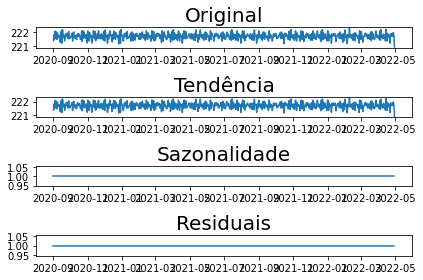

In [24]:
seasonal_decompose_analysis ( ts_1d , 'multiplicativo' , 365 )


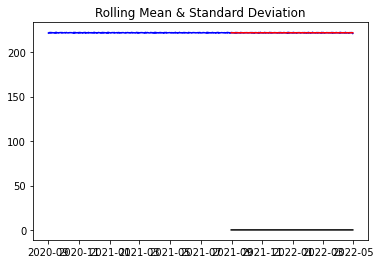

Results of Dickey-Fuller Test
Test Statistic                -1.210357e+01
p-value                        1.992561e-22
#Lags Used                     1.900000e+01
Number of Observations Used    5.870000e+02
Critical Value (1%)           -3.441539e+00
Critical Value (5%)           -2.866476e+00
Critical Value (10%)          -2.569399e+00
dtype: float64


In [25]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(timeseries, rolling_window):
    rolling_mean = pd.Series(timeseries).rolling(window=rolling_window).mean()
    rolling_std = pd.Series(timeseries).rolling(window=rolling_window).std()
    
    orig = plt.plot(timeseries, color='blue', label= 'Original')
    mean = plt.plot(rolling_mean, color='red', label= 'Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    
stationarity_test(timeseries = ts_1d, rolling_window = 365)

In [ ]:
stationarity_test ( timeseries  =  ts_1d_log . dropna (), rolling_window  =  365 )

In [ ]:
t_ratio = 0.95
t_size = int(len(ts_1d_log) * t_ratio)

train_1d_log, test_1d_log = ts_1d_log[:t_size].asfreq('D'), ts_1d_log[t_size:].asfreq('D')

print("Original Data Length =", len(ts_1d_log))
print("Training Data Length =", len(train_1d_log))
print("Test Data Length     =", len(test_1d_log))

# Original Data Length = 763
# Training Data Length = 724
# Test Data Length     = 39

In [ ]:
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_1d_log,
                            order=(2, 1, 4),
                            seasonal_order=(0, 1, 0, 365),
                            enforce_invertibility=False,
                            enforce_stationarity=False)

result_sarima = sarima_model.fit()

print('SARIMA - AIC : {}'.format(result_sarima.aic))

# SARIMA - AIC : -296.90534927970805

In [ ]:
pred_sarima = result_sarima.predict(start=0, end=800)

plt.title('Model Fitting and Forecasting', fontsize=32)
plt.xlabel('Future Time (in Days)', fontsize=20)
plt.ylabel('Predicted Avg. Daily RPM', fontsize=20)

plt.plot(train_1d_log, label='Training')
plt.legend(loc='best')
           
plt.plot(test_1d_log, label='Test')
plt.legend(loc='best')

plt.plot(pred_sarima['2018-12-26':'2019-02-02'], label='Predicted')
plt.legend(loc='best')

In [ ]:
mse_38d = mean_squared_error(np.exp(test_1d_log), np.exp(pred_sarima_214_010_365_1d_log['2018-12-26':'2019-02-02']))
rmse_38d = np.sqrt(mse_38d)
cov_38d = rmse_38d / (np.exp(test_1d_log)).mean() * 100

print ("Mean Squared Error (MSE) =", mse_38d)
print ("Root Mean Squared Error (RMSE) =", rmse_38d)
print ("Coefficient of Variation =", cov_38d, "%")

# Mean Squared Error (MSE) = 2071.720645305662
# Root Mean Squared Error (RMSE) = 45.51615806837899
# Coefficient of Variation = 11.645373540724746 %